In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve,plot_precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, cohen_kappa_score,balanced_accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

###  <font color='navy'>Data Exploration </font>

In [2]:
# read imdb movie review sentiment file into pandas
rt_reviews = pd.read_csv('rottenReview_backup_xl.csv')
rt_reviews.head(2)

,Reviews,StarRating
0,Narrated the whole time...really weird and not...,STAR_0_5
1,"Decent watch, could watch again, but hard to r...",STAR_3


In [3]:
# rename columns to review and StarRating
rt_reviews.columns = ['review', 'StarRating']

In [4]:
#Dimensions of the dataset
rt_reviews.shape

(169669, 2)

In [5]:
# examine the dataframe, no missing data
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169669 entries, 0 to 169668
Data columns (total 2 columns):
review        169669 non-null object
StarRating    169669 non-null object
dtypes: object(2)
memory usage: 2.6+ MB


In [6]:
# the reviews have html tags. double quotations, brackets, hyphen and emojis that should be removed in preprocessing.
rt_reviews.iloc[74, 0]

'This is a very stupid movie it is a waste pf money and talent, Anne sorry but in this movie she is very bad, and rebel , well, os rebel most of her movies are very bad this is not the exception this movie nobody will remember it , thanks god 😒'

In [7]:
# How many categories of star rating
rt_reviews.StarRating.unique()
# Ranges from 0.5 star to 5 stars (10 levels)

array(['STAR_0_5', 'STAR_3', 'STAR_2', 'STAR_1', 'STAR_3_5', 'STAR_5',
       'STAR_2_5', 'STAR_4', 'STAR_1_5', 'STAR_4_5'], dtype=object)

In [8]:
# Examie the distribution of ratings
rt_reviews.StarRating.value_counts().sort_index()

STAR_0_5    12371
STAR_1       8751
STAR_1_5     4550
STAR_2       9119
STAR_2_5     7347
STAR_3      14293
STAR_3_5    14454
STAR_4      26209
STAR_4_5    13274
STAR_5      59301
Name: StarRating, dtype: int64

In [9]:
# Examie the distribution of ratings as percentage
rt_reviews.StarRating.value_counts(normalize=True).sort_index()
# roughly 25% are below 3 star , imbalanced dataset

STAR_0_5    0.072913
STAR_1      0.051577
STAR_1_5    0.026817
STAR_2      0.053746
STAR_2_5    0.043302
STAR_3      0.084240
STAR_3_5    0.085189
STAR_4      0.154471
STAR_4_5    0.078235
STAR_5      0.349510
Name: StarRating, dtype: float64

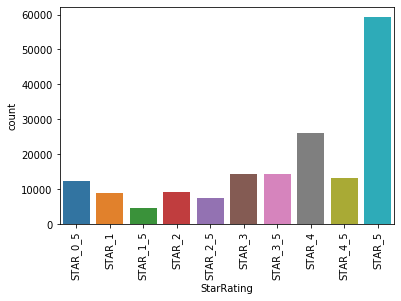

In [10]:
# plot the positive / negative classes as frequencies
s = sns.countplot(x='StarRating', data=rt_reviews, order=rt_reviews.StarRating.value_counts().index.sort_values())
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [11]:
# longest, shortest and avg review lengths
review_length = rt_reviews.review.str.len()
print('longest review is', review_length.max(), 'chracters long')
print('shortest review is',review_length.min(), 'chracters long')
print('average review is ',int(review_length.mean()), 'chracters long')

longest review is 55269 chracters long
shortest review is 10 chracters long
average review is  218 chracters long


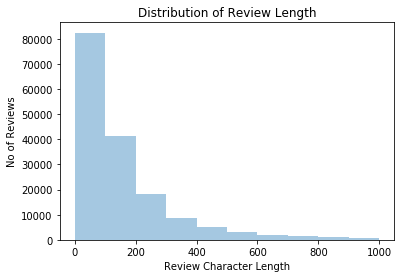

In [12]:
s = sns.distplot(review_length, bins=[0,100,200,300,400,500,600,700,800,900,1000], kde=False)
s.set_xlabel('Review Character Length')
s.set_ylabel('No of Reviews')
s.set_title('Distribution of Review Length')
plt.show()

###  <font color='navy'>Pre-processing </font>

In [13]:
# convert StarRating into numerical as sklearn expects target variable to be numeric
# 0.5 t0 2.5 => negative sentiment and 3-5 stars = positive sentiment (5 levels in each)
mapping = {'STAR_0_5': 0, 'STAR_1':0, 'STAR_1_5':0, 'STAR_2':0, 'STAR_2_5':0, 
          'STAR_3':1, 'STAR_3_5':1, 'STAR_4':1, 'STAR_4_5':1, 'STAR_5': 1}

# create a new column sentiment
rt_reviews['sentiment'] = rt_reviews.StarRating.map(mapping)

In [14]:
# 75% positive and 25% negative sentiment, slighty imbalaced dataset
rt_reviews.sentiment.value_counts(normalize=True)

1    0.751646
0    0.248354
Name: sentiment, dtype: float64

In [15]:
# check the target column is mapped correctly
rt_reviews.head()

,review,StarRating,sentiment
0,Narrated the whole time...really weird and not...,STAR_0_5,0
1,"Decent watch, could watch again, but hard to r...",STAR_3,1
2,It wasn't as bad as the critics said it was. A...,STAR_3,1
3,I actually thought this was funny. The ending ...,STAR_3,1
4,"I liked this better the first time I saw it, w...",STAR_3,1


In [16]:
# Text processing steps

#convert everything to lower case
rt_reviews['review_clean'] = rt_reviews.review.str.lower()

# remove numbers 
rt_reviews['review_clean'] = rt_reviews.review_clean.str.replace('[0-9]+', '') # match one or more digits

# remove html tags
regex_html = r'<\s*[^>]*>|<\s*/\s*>' #this regular exression will match all html tags
rt_reviews['review_clean'] = rt_reviews.review_clean.str.replace(regex_html, '')

# remove Punctuations
regex_punctuations = r'[^\w\s]' #match anything not a digit/letter/underscore or space
rt_reviews['review_clean'] = rt_reviews.review_clean.str.replace(regex_punctuations, ' ')
rt_reviews['review_clean'] = rt_reviews.review_clean.str.replace('_', '')  # remove underscore too

In [17]:
rt_reviews['review_clean'].head()

0    narrated the whole time   really weird and not...
1    decent watch  could watch again  but hard to r...
2    it wasn t as bad as the critics said it was  a...
3    i actually thought this was funny  the ending ...
4    i liked this better the first time i saw it  w...
Name: review_clean, dtype: object

In [18]:
# Instantiate the CountVectorizer
countvec = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
bag = countvec.fit_transform(rt_reviews.review_clean)

In [19]:
# look at the dimensions of the sparse matrix
bag.shape
# vocabulary of 69.5K words , lets try to reduce this

(169669, 69563)

##### <b>*Stemming* </b>

In [20]:
# stemmer will only work on tokenized words not sentences. We will define a function to do this. 
def getRootWords(sentence) :
    #instantiate stemmer 
    stemmer=SnowballStemmer("english") # the english stemmer is an improvement on the original porter stemmer
    
    #tokenize the sentence
    tokens = word_tokenize(sentence)
    
    # stem the tokens
    root_tokens= [stemmer.stem(word) for word in tokens]
    
    # join words together to form sentence again 
    root_sentence = ' '.join(root_tokens)
    
    return root_sentence

In [21]:
#  Stemming Example: watching, watch, watched =>'watch' and movie, movies +> movi
sentence = '''I love watching movies. I have watched over 50 movies since the lockdown began. In fact I will watch one movie tonight'''
getRootWords(sentence)

'i love watch movi . i have watch over 50 movi sinc the lockdown began . in fact i will watch one movi tonight'

In [22]:
# stem each review to reduce the vocabulary 
rt_reviews['review_stemmed'] = rt_reviews.review_clean.apply(getRootWords)

In [23]:
# if we stem text then we must stem stopwords too
stemmer=SnowballStemmer("english")
stop_words_stemmed = [stemmer.stem(word) for word in ENGLISH_STOP_WORDS]

In [24]:
# see how many words changed from iriginal stop words
print(set(stop_words_stemmed).difference(ENGLISH_STOP_WORDS))

{'whi', 'howev', 'someth', 'hereaft', 'twenti', 'onli', 'themselv', 'noth', 'therebi', 'becom', 'empti', 'dure', 'sixti', 'noon', 'everywher', 'whenc', 'thenc', 'becaus', 'abov', 'yourselv', 'alway', 'everyth', 'forti', 'sincer', 'befor', 'sometim', 'sinc', 'describ', 'togeth', 'wherebi', 'anoth', 'alon', 'someon', 'whatev', 'afterward', 'otherwis', 'henc', 'ourselv', 'sever', 'hundr', 'wherea', 'cri', 'anywher', 'twelv', 'mani', 'whenev', 'inde', 'besid', 'nobodi', 'becam', 'pleas', 'everi', 'alreadi', 'herebi', 'anyth', 'ani', 'moreov', 'nowher', 'onc', 'fifti', 'els', 'perhap', 'thereaft', 'veri', 'somewher', 'therefor', 'wherev', 'elsewher', 'whereaft', 'everyon', 'anyon', 'meanwhil'}


In [25]:
# stemmed bag of words
countvec_stem= CountVectorizer(stop_words=stop_words_stemmed)
bag_stem = countvec_stem.fit_transform(rt_reviews.review_stemmed)
bag_stem.shape

(169669, 48678)

*Stemming has reduced no of features from 69563 to 48678K, so a significant reduction*

In [26]:
# create a word cloud
corpus = rt_reviews.review_stemmed.str.cat(sep=' ') #concat all reviews into one big string
word_cloud= WordCloud(background_color='white', stopwords=stop_words_stemmed,collocations=False).generate(corpus)

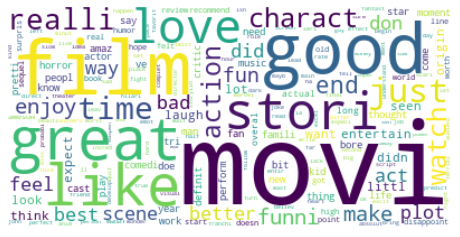

In [27]:
# Display the generated wordcloud image (both postive and negative)
plt.figure(figsize=(8,5)) 
plt.imshow(word_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [28]:
# split the dataframe into positive and negative reviews
positive_reviews = rt_reviews[rt_reviews.sentiment == 1] # positive sentiment
negative_reviews = rt_reviews[rt_reviews.sentiment == 0] # negative sentiment

In [29]:
#generate positive and negative word clouds
positive_corpus = positive_reviews.review_stemmed.str.cat(sep=' ')
positive_word_cloud= WordCloud(background_color='white', stopwords=stop_words_stemmed,collocations=False).generate(positive_corpus)

negative_corpus = negative_reviews.review_stemmed.str.cat(sep=' ')
negative_word_cloud= WordCloud(background_color='white',stopwords=stop_words_stemmed, collocations=False).generate(negative_corpus)

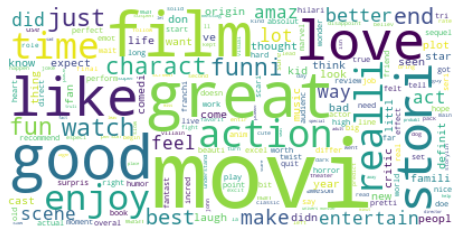

In [30]:
# show the positive wordcloud image
plt.figure(figsize=(8,5))
plt.imshow(positive_word_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

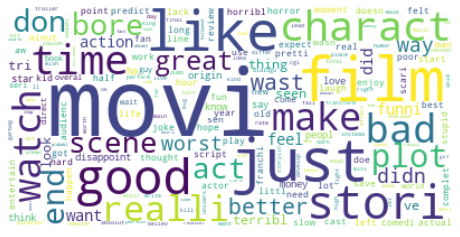

In [31]:
# show the negative wordcloud image
plt.figure(figsize=(8,5))
plt.imshow(negative_word_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

##### <b>*Context & ngrams* </b>

In [32]:
print(len(stop_words_stemmed))

# update the stop_words to include a few words that may make the context clearer (eg: not not good, not bad etc)
mylist = ['not', 'never', 'alway', 'interest']
for word in mylist : 
    stop_words_stemmed.remove(word)

#remove a few movie related stopwords showed in the word clouds
movie_related_stopwords = ['movi', 'film', 'act', 'watch', 'scene']
stop_words_stemmed = stop_words_stemmed + movie_related_stopwords
# print the no of updated stopwords
print(len(stop_words_stemmed))

318
319


##### <b>*Random undersampling to create a balanced dataset* </b>

In [33]:
# size of total negative reviews
total_neg_reviews = negative_reviews.shape[0]
total_neg_reviews

42138

In [34]:
# size of positive reviews
positive_reviews.shape[0]

127531

In [35]:
#set seed
SEED = 1411 # for reproducibility

In [36]:
#we will build a random sample positive review that is the same size as negative views
np.random.seed(SEED)
mask = np.random.choice(positive_reviews.index.values, total_neg_reviews, replace=False)
positive_reviews_sampled = positive_reviews.loc[mask]

In [37]:
#dataframe consisting of postive reviews not sampled
mask_excluded = set(positive_reviews.index).difference(set(mask))
print(len(mask_excluded))
positive_reviews_not_sampled = positive_reviews.loc[mask_excluded]

85393


In [38]:
#sampled positive dataframe has the same no of reviews as positive
positive_reviews_sampled.shape[0]

42138

In [39]:
#create a balanced dataset
rt_reviews_balanced = pd.concat([negative_reviews,positive_reviews_sampled], axis=0)
rt_reviews_balanced.shape

(84276, 5)

In [40]:
# Define X and target 
X = rt_reviews_balanced.review_stemmed
y = rt_reviews_balanced.sentiment.values # as numpy array

In [41]:
# also create test sets for the postive reviews excluded (to check the classification accuracy later)
X_postive_data = positive_reviews_not_sampled.review_stemmed
y_positive = positive_reviews_not_sampled.sentiment.values

In [42]:
#split the data into training and test sets, this step is done even before Vectorizing the reviews(text). 

# 80% training 20% test, dataset split in stratifed fashion (becuase positive and negative were joined)
X_data_train, X_data_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

###  <font color='navy'>I.  Train and Compare ML Models using Bag-of-Words </font>

In [43]:
# max no of features (unigrams and bigrams)
MAX_FEATURES=1000 # roughly 2% of the total unigrams

#  build a vocabulary that only considers the top max_features ordered by term frequency across the corpus
countvec = CountVectorizer(max_features=MAX_FEATURES, stop_words=stop_words_stemmed, ngram_range=(1,2))
bag = countvec.fit_transform(X_data_train) 

# Create X_train and X_test
X_train_bow= bag.toarray() # scikit learn cant work with sparse matrices, so convert bag of words to numpy array

# No refitting. Only transform using the CountVectorizer fitted on training data.  Absolutely no cheating !!
X_test_bow = countvec.transform(X_data_test).toarray()

#samples excluded
X_positive_bow = countvec.transform(X_postive_data)

In [44]:
# get a list features selected based on term frequency (5000 in total)
features = countvec.get_feature_names()

In [45]:
# find all bigrams amoung the selected features 
bigrams = [word for word in features if ' ' in word]
print(len(bigrams))
# of the 1000 features selected, roughly 10% are bigrams

94


In [46]:
# print some bigrams
print(bigrams [:5])

['action pack', 'action sequenc', 'ant man', 'bad guy', 'begin end']


In [47]:
# check if we are right to allow some stopwords
print([word for word in bigrams if word.startswith('not')])

['not bad', 'not best', 'not expect', 'not funni', 'not good', 'not great', 'not like', 'not realli', 'not recommend', 'not scari', 'not sure', 'not worth']


In [48]:
# find the top most frequent words
sum_words = bag.sum(axis=0)  # contains the sum of each word occurrence in all texts in the corpus
words_freq = {word :sum_words[0, idx] for word, idx in countvec.vocabulary_.items()}

#sort the dictionary by term frequency
words_freq = {word: freq for word, freq in sorted(words_freq.items(), key=lambda item: item[1], reverse=True)} 

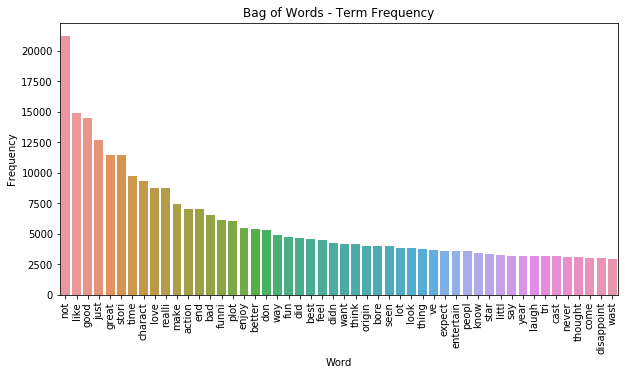

In [49]:
#plot the frequencies of the top 50 words.
vocabulary_sorted = list(words_freq.keys())
freq_sorted = list(words_freq.values())
plt.figure(figsize=(10,5))
s=sns.barplot(x=vocabulary_sorted[:50],y=freq_sorted[:50])
s.set_title('Bag of Words - Term Frequency')
s.set_xlabel('Word')
s.set_ylabel('Frequency')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

##### <b> *we will fit 4 classifiers to the training data and compare them*</b>

In [50]:
# instantiate all classifiers with default settings
rf_clf = RandomForestClassifier(random_state=SEED)
nb_clf = MultinomialNB() #MultinomialNB works well with BOW sparse matrices
sgdsvc_clf =SGDClassifier(loss='hinge', random_state=SEED)
sgdlog_clf = SGDClassifier(loss='log', random_state=SEED)

In [51]:
#name of the classifiers in the same order as classifiers
names = ['Random Forest', 'Naive Bayes', 'SGD-Linear SVC', 'SGD-Logistic Regression']

In [52]:
# make a list of classifiers  
classifiers = [rf_clf, nb_clf, sgdsvc_clf, sgdlog_clf]

In [53]:
# Metrics of interest 
meancv_scores_list = []
accuracy_list = []
precision_list=[]
recall_list =[]
f1score_list=[]
kappa_list =[]

In [54]:
# for each classifier in the classifier above do the following
for clf in classifiers:
    
    #perform a 5-fold CV
    cv_scores = cross_val_score(clf,X_train_bow,y_train,cv=5)
    
    #append the mean of the cross val scores to the mean_cv_scores list
    meancv_scores_list.append(cv_scores.mean())
    
    # fit the classifier to the entire training set 
    clf.fit(X_train_bow, y_train)
    
    # predict test values
    y_pred = clf.predict(X_test_bow)
    
    # calculate and append the metrics of interest
    accuracy_list.append(accuracy_score(y_test, y_pred)) 
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1score_list.append(f1_score(y_test, y_pred))
    kappa_list.append(cohen_kappa_score(y_test, y_pred))

In [55]:
#create a summary dataframe  
df_summary_bow = pd.DataFrame(list(zip(names, meancv_scores_list,accuracy_list,precision_list,recall_list,f1score_list,kappa_list)),
                          columns=['Classifier','Avg CV Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa']
                         )

In [136]:
df_summary_bow.round(3)

,Classifier,Avg CV Score,Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest,0.821,0.817,0.821,0.812,0.816,0.635
1,Naive Bayes,0.830,0.828,0.821,0.838,0.830,0.656
2,SGD-Linear SVC,0.837,0.840,0.855,0.819,0.837,0.681
3,SGD-Logistic Regression,0.838,0.838,0.825,0.857,0.841,0.675


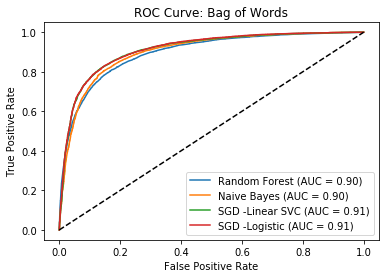

In [57]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(rf_clf, X_test_bow, y_test, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(nb_clf, X_test_bow, y_test, name='Naive Bayes', ax=ax)
plot_roc_curve(sgdsvc_clf, X_test_bow, y_test, name='SGD -Linear SVC',ax=ax)
plot_roc_curve(sgdlog_clf, X_test_bow, y_test, name='SGD -Logistic', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve: Bag of Words')
plt.show()

In [135]:
#create a dataframe with model coefficents and feature names
df_coef_bow = pd.DataFrame({'features':  countvec.get_feature_names(),  'coef' : sgdsvc_clf.coef_.ravel()})
df_coef_bow.sort_values(by='coef', ascending=False, inplace=True)
df_coef_bow.reset_index(drop=True).round(2)

,features,coef
0,bo tak,4.02
1,tak bo,4.02
2,tak,3.73
3,not bad,1.38
4,awesom,1.36
...,...,...
995,bland,-1.42
996,wast,-1.45
997,mediocr,-1.48
998,worst,-1.57


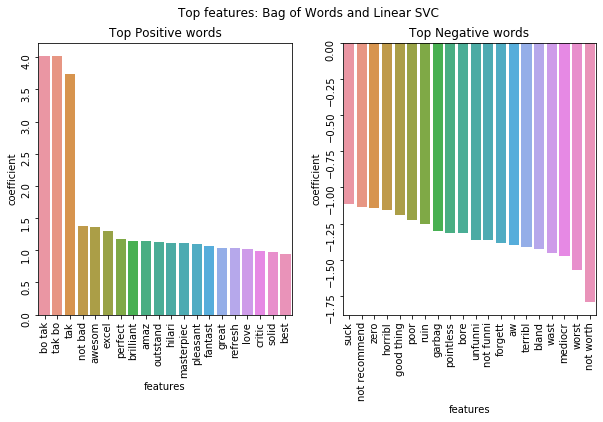

In [59]:
# top 20 positive and negative features
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(x=df_coef_bow.iloc[0:20, 0],y=df_coef_bow.iloc[0:20, 1], ax=ax[0])
ax[0].set_title('Top Positive words')
ax[0].set_ylabel('coefficient')
ax[0].tick_params(labelrotation=90)
sns.barplot(x=df_coef_bow.iloc[-20:, 0],y=df_coef_bow.iloc[-20:, 1], ax=ax[1])
ax[1].set_title('Top Negative words')
ax[1].set_ylabel('coefficient')
ax[1].tick_params(labelrotation=90)
plt.suptitle('Top features: Bag of Words and Linear SVC')
plt.show()

*Interesting observations : </br> Eventhough bigrams accounted for only 10% of the 1000 features, 8 bigrams (20%, 3 positive and 5 negetive) made it to the top 20 positive & negative features </br>
The bigram 'not bad' has the 4th highest positive coefficent*

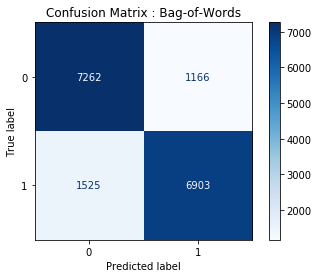

In [60]:
#plot confusion matrix counts.(Note unlike R, in scikit learn the True obervations are given in rows and prediction in columns)
plot_confusion_matrix(sgdsvc_clf, X_test_bow, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix : Bag-of-Words')
plt.show()

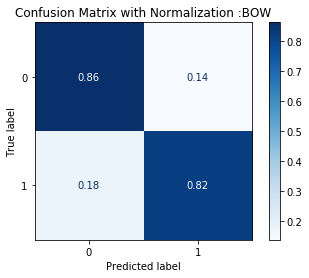

In [61]:
#plot confusion matrix counts.(Note unlike R, in scikit learn the True obervations are given in rows and prediction in columns)
plot_confusion_matrix(sgdsvc_clf, X_test_bow, y_test,cmap=plt.cm.Blues, normalize='true')  
plt.title('Confusion Matrix with Normalization :BOW')
plt.show()

In [62]:
y_pred_bow = sgdsvc_clf.predict(X_test_bow)
# classification report 
print(classification_report(y_test, y_pred_bow))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      8428
           1       0.86      0.82      0.84      8428

    accuracy                           0.84     16856
   macro avg       0.84      0.84      0.84     16856
weighted avg       0.84      0.84      0.84     16856



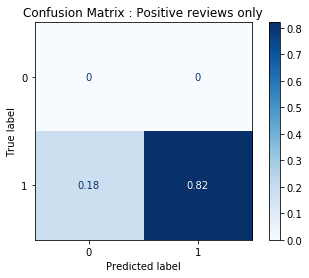

In [63]:
# Confusion matrix for the positive classes excluded in the sampling
plot_confusion_matrix(sgdsvc_clf, X_positive_bow, y_positive,cmap=plt.cm.Blues, normalize='true')  
plt.title('Confusion Matrix : Positive reviews only')
plt.show()

###  <font color='navy'>II. Prediction using TF-IDF sparse matrix and  multiple Classifiers</font>

In [64]:
#instantiate the Vectorizer
# Tfidf_vect  = TfidfVectorizer(max_features=MAX_FEATURES, stop_words=stop_words_stemmed, ngram_range=(1,2))
Tfidf_vect  = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1,2))

In [65]:
#similar to what we did before for countvec. 
bag_tfidf = Tfidf_vect.fit_transform(X_data_train) 

In [66]:
# Create X_train and X_test
X_train_tfidf= bag_tfidf.toarray() # scikit learn cant work with sparse matrices, so convert csr matrix to numpy array

# No refitting. Only transformation using the TfidfVectorizer fitted on training data.  otherwsie it would be cheating
X_test_tfidf = Tfidf_vect.transform(X_data_test).toarray()

In [67]:
# Postive samples excluded
X_positive_tfidf = Tfidf_vect.transform(X_postive_data).toarray()

In [68]:
# instantiate all classifiers with default settings
clf_rf = RandomForestClassifier(random_state=SEED)
clf_nb = MultinomialNB() 
clf_sgdsvc =SGDClassifier(loss='hinge', random_state=SEED)
clf_sgdlog = SGDClassifier(loss='log', random_state=SEED)

In [69]:
# make a list of classifiers  
classifiers = [clf_rf, clf_nb, clf_sgdsvc, clf_sgdlog]

In [70]:
#name of the classifiers in the same order as classifiers
names = ['Random Forest', 'Naive Bayes', 'SGD-Linear SVC', 'SGD-Logistic Regression']

In [71]:
# Metrics of interest 
mean_cv_scores = []
clf_accuracy = []
clf_precision=[]
clf_recall = []
clf_f1score=[]
clf_kappa =[]

In [72]:
# for each classifier in the classifier above do the following.
for clf in classifiers:
    
    #perform a 5-fold CV
    cv_scores = cross_val_score(clf,X_train_tfidf,y_train,cv=5)
    
    #append the mean of the cross val scores to the mean_cv_scores list
    mean_cv_scores.append(cv_scores.mean())
    
    # fit the classifier to the entire training set 
    clf.fit(X_train_tfidf, y_train)
    
    # predict test values
    y_pred = clf.predict(X_test_tfidf)
    
    # calculate and append the metrics of interest
    clf_accuracy.append(accuracy_score(y_test, y_pred)) 
    clf_precision.append(precision_score(y_test, y_pred))
    clf_recall.append(recall_score(y_test, y_pred))
    clf_f1score.append(f1_score(y_test, y_pred))
    clf_kappa.append(cohen_kappa_score(y_test, y_pred))

In [73]:
#create a summary dataframe  
df_summary = pd.DataFrame(list(zip(names, mean_cv_scores,clf_accuracy,clf_precision,clf_recall, clf_f1score,clf_kappa)),
                          columns=['Classifier','Avg CV Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa']
                         )

In [134]:
df_summary.round(3)

,Classifier,Avg CV Score,Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest,0.830,0.831,0.841,0.815,0.828,0.661
1,Naive Bayes,0.828,0.829,0.844,0.808,0.826,0.659
2,SGD-Linear SVC,0.840,0.847,0.850,0.842,0.846,0.694
3,SGD-Logistic Regression,0.842,0.843,0.850,0.834,0.842,0.687


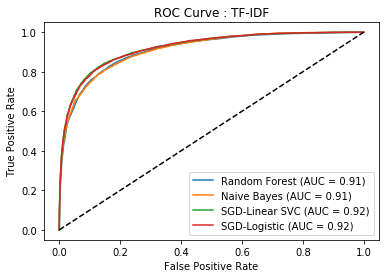

In [75]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(clf_rf, X_test_tfidf, y_test, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(clf_nb, X_test_tfidf, y_test, name='Naive Bayes', ax=ax)
plot_roc_curve(clf_sgdsvc, X_test_tfidf, y_test, name='SGD-Linear SVC', ax=ax)
plot_roc_curve(clf_sgdlog, X_test_tfidf, y_test, name='SGD-Logistic', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve : TF-IDF')
plt.show()

##### <b> *Fine tuning the best class (hyperparameter optimization)*</b>

In [76]:
# default alpha value is 0.0001
clf_sgdsvc.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1411,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [77]:
# We set random_state for reproducibility 
clf_sgd = SGDClassifier(loss ='hinge', random_state=SEED)

# Instantiate the GridSearchCV object 
param_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1],  # alpha is the regularization parameter (higher alpha means more regulization) default is 0.0001
             }  

gs_sgd = GridSearchCV(estimator=clf_sgd, 
                      param_grid=param_grid, 
                      cv=5, 
                      scoring = 'roc_auc',
                    return_train_score=True,
                        verbose=0)

In [78]:
# run grid search (i.e fit training data)
gs_sgd.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(random_state=1411),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
             return_train_score=True, scoring='roc_auc')

In [79]:
# get the top area under ROC curve (training set)
gs_sgd.best_score_

0.9213917814721533

In [80]:
# find the best estimator
gs_sgd.best_estimator_.get_params() 

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1411,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [81]:
#actually the best model is still the model we got with the default setting !
gs_sgd.best_estimator_.get_params()== clf_sgdsvc.get_params()

True

In [82]:
#accuracy of the optimized model 
sgd_best = gs_sgd.best_estimator_
sgd_best.score(X_test_tfidf, y_test)

0.8469387755102041

In [83]:
# predict sentimet of test set
y_pred_tfidf = sgd_best.predict(X_test_tfidf)

In [84]:
#print the confusion matrix (Note unlike R, in python the actuals obervations are given in rows and prediction in columns)
print(confusion_matrix(y_pred_tfidf, y_pred))

[[8318  188]
 [ 264 8086]]


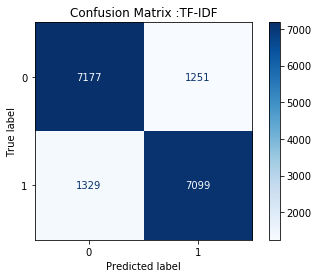

In [85]:
#plot confusion matrix counts.(Note unlike R, in scikit learn the True obervations are given in rows and prediction in columns)
plot_confusion_matrix(sgd_best, X_test_tfidf, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix :TF-IDF')
plt.show()

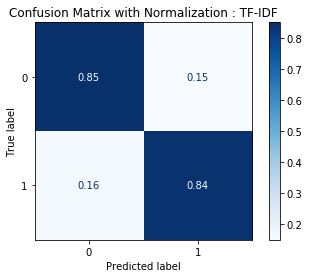

In [86]:
#plot confusion matrix normalized (Note unlike R, in scikit learn the true obervations are given in rows and prediction in columns)
plot_confusion_matrix(sgd_best, X_test_tfidf, y_test, cmap=plt.cm.Blues,normalize='true')  
plt.title('Confusion Matrix with Normalization : TF-IDF')
plt.show()

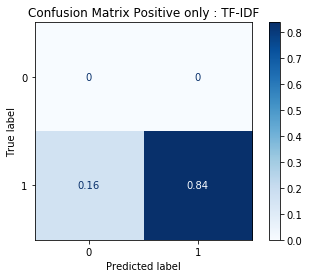

In [87]:
#plot confusion matrix normalized (Note unlike R, in scikit learn the true obervations are given in rows and prediction in columns)
plot_confusion_matrix(sgd_best, X_positive_tfidf, y_positive, cmap=plt.cm.Blues,normalize='true')  
plt.title('Confusion Matrix Positive only : TF-IDF')
plt.show()

In [88]:
# classification report 
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      8428
           1       0.85      0.84      0.85      8428

    accuracy                           0.85     16856
   macro avg       0.85      0.85      0.85     16856
weighted avg       0.85      0.85      0.85     16856



In [129]:
#create a dataframe with model coefficents and feature names
df_coef = pd.DataFrame({'features':  Tfidf_vect.get_feature_names(),  'coef' : sgd_best.coef_.ravel()})
df_coef.sort_values(by='coef', ascending=False, inplace=True)
df_coef.reset_index(drop=True).round(2)

,features,coef
0,great,3.74
1,amaz,3.73
2,enjoy,3.52
3,fun,3.51
4,awesom,3.43
...,...,...
995,wast,-3.08
996,poor,-3.23
997,terribl,-3.55
998,worst,-3.72


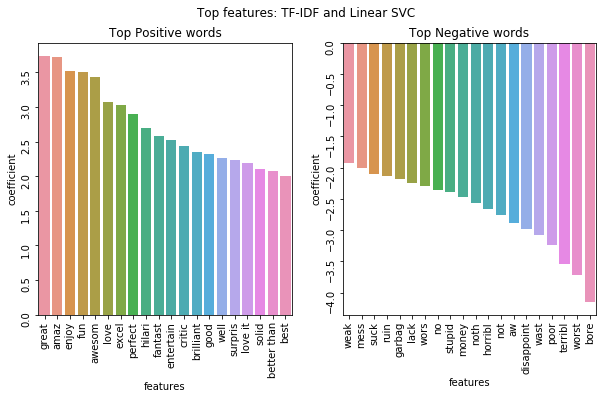

In [90]:
# top 20 postive and negative words
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.barplot(x=df_coef.iloc[0:20, 0],y=df_coef.iloc[0:20, 1], ax=ax[0])
ax[0].set_title('Top Positive words')
ax[0].set_ylabel('coefficient')
ax[0].tick_params(labelrotation=90)
sns.barplot(x=df_coef.iloc[-20:, 0],y=df_coef.iloc[-20:, 1], ax=ax[1])
ax[1].set_title('Top Negative words')
ax[1].set_ylabel('coefficient')
ax[1].tick_params(labelrotation=90)
plt.suptitle('Top features: TF-IDF and Linear SVC ')
plt.show()

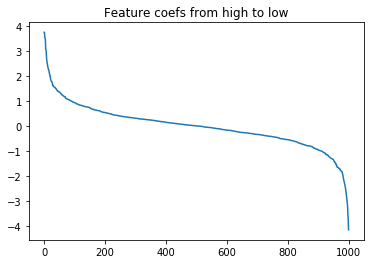

In [91]:
# L2 penatly shriks non-contributing coefficents towards zero (can aid in feature selection)
plt.plot(np.arange(0,1000), df_coef.coef)
plt.title('Feature coefs from high to low')
plt.show()

In [92]:
# out of the 1000 features only 177 has a coefficent >1
df_coef[abs(df_coef.coef)>1].shape[0]

177

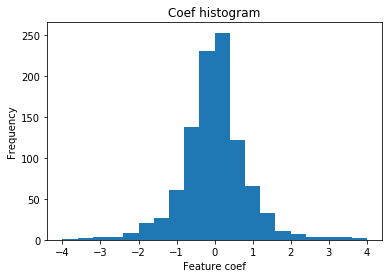

In [93]:
# features coefs historgram (same info presented differently)
plt.hist(df_coef.coef, bins=20, range=[-4,4])
plt.xlabel('Feature coef')
plt.ylabel('Frequency')
plt.title('Coef histogram')
plt.show()

### Appendix 1 : How many features ? 

*The choice of 1000 features was arbitrary (the idea was we would selected rouhgly 2% of the total unigrams). Here we will examine could we have done much better by selecting more features ? (by using the best class of model Linear SVC and tf-idf matrix)*

In [94]:
# max features to iterate over 
max_features_list = [100, 200, 500, 1000, 2000, 5000, 10000]

#lists to save the results
accuracy_fs = []

for FEATURES_MAX in max_features_list:
    #instantiate the Vectorizer
    vect_tfidf  = TfidfVectorizer(max_features=FEATURES_MAX) 
    
    #create test and training sets (X variables)
    X_train_featureselect = vect_tfidf.fit_transform(X_data_train).A # dot A is the same as toarray()
    X_test_featureselect = vect_tfidf.transform(X_data_test).A
    
    # instantiate the Linear SVC classifier 
    sgd_svc = SGDClassifier(loss='hinge', random_state=SEED)
    
    # train the model 
    sgd_svc.fit(X_train_featureselect, y_train)
    
    # make prediction
    y_pred_fs = sgd_svc.predict(X_test_featureselect)
    
    #append accuracy to the list 
    accuracy_fs.append(accuracy_score(y_test, y_pred_fs))

In [128]:
#create a summary dataframe  
df_numfeatures = pd.DataFrame(list(zip(max_features_list, accuracy_fs)),
                          columns=['No of features','Accuracy']
                         )
df_numfeatures.round(3)

,No of features,Accuracy
0,100,0.726
1,200,0.781
2,500,0.831
3,1000,0.845
4,2000,0.853
5,5000,0.860
6,10000,0.860


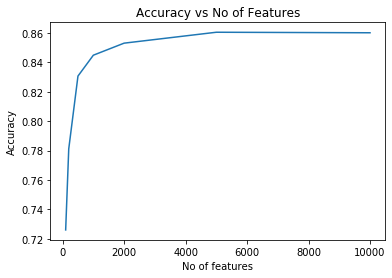

In [96]:
# plot no of featres vs accuracy 
fig , ax = plt.subplots()
ax.plot(df_numfeatures['No of features'], df_numfeatures['Accuracy'])
ax.set_title('Accuracy vs No of Features')
ax.set_ylabel('Accuracy')
ax.set_xlabel('No of features')
plt.show()

*It looks like we could have done a little better by choosing more features. The difference in accuracy between 1000 features and 5000 features is  1.6%. However beyond 5000 features adding more features makes no difference to accuracy of the model.

### Appendix 2 : Dimensionality Reduction with Feature Selection

In [97]:
# we will start with the best model with 1000 features, recall it had only 177 features with coef greater than 1
df2 = df_coef[abs(df_coef.coef)>1]
my_vocabulary = list(df2.features)
len(my_vocabulary)

177

In [98]:
#instantiate the Vectorizer with the features with higher coefs only
Tfidf_vect_short  = TfidfVectorizer(vocabulary=my_vocabulary) 

# create training and test X variables
X_train_short = Tfidf_vect_short.fit_transform(X_data_train).A
X_test_short = Tfidf_vect_short.transform(X_data_test).A

In [99]:
# instantiate the classifer and train 
sgd_short = SGDClassifier(loss='log', random_state=SEED)
sgd_short.fit(X_train_short, y_train)
sgd_short.score(X_test_short, y_test)

0.8201233981964879

In [100]:
#calculate the area under ROC
y_pred_short = sgd_short.predict(X_test_short)

y_short_pred_proba =sgd_short.predict_proba(X_test_short)[:,1]
roc_auc_score(y_test,y_short_pred_proba)

0.9047365379690138

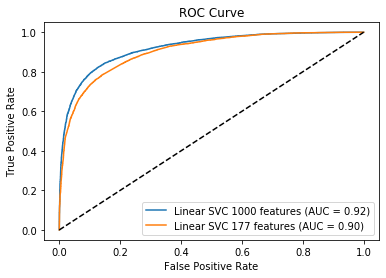

In [101]:
# plot roc curve 
fig, ax = plt.subplots()
plot_roc_curve(sgd_best, X_test_tfidf, y_test, name='Linear SVC 1000 features', ax=ax)
plot_roc_curve(sgd_short, X_test_short, y_test, name='Linear SVC 177 features', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.show()

### Appendix 3 : Voting Classifer

In [102]:
classfier_list =[ ('SGD -Linear SVM', clf_sgdsvc),('random forest', clf_rf), ('Naive Bayes', clf_nb),('SGD -Logistic', clf_sgdlog)]
# instantiate voting classifier VC
voting_clf = VotingClassifier(estimators = classfier_list, voting ='hard')
# Hard votig =>  Majority voting
# if it is a tie (i.e 2 positive and 2 negative), the Voting classifier will choose the prediction of the 1st classier. 
# therefore we will put the 'best classifer' Linear SVM as the first

In [103]:
#fit vc to the training set and predict test labels
voting_clf.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('SGD -Linear SVM',
                              SGDClassifier(random_state=1411)),
                             ('random forest',
                              RandomForestClassifier(random_state=1411)),
                             ('Naive Bayes', MultinomialNB()),
                             ('SGD -Logistic',
                              SGDClassifier(loss='log', random_state=1411))])

In [104]:
#accuracy of the voting classifier
voting_clf.score(X_test_tfidf, y_test)

0.8453369719981015

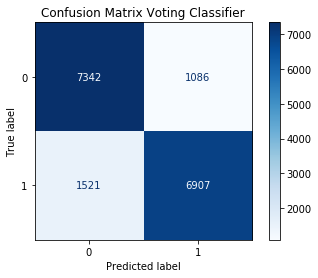

In [105]:
# plot confusion matrix for voting classifer normalized
plot_confusion_matrix(voting_clf, X_test_tfidf, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix Voting Classifier')
plt.show()

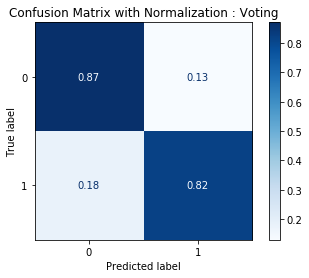

In [106]:
# plot confusion matrix for voting classifer normalized
plot_confusion_matrix(voting_clf, X_test_tfidf, y_test,cmap=plt.cm.Blues, normalize='true')  
plt.title('Confusion Matrix with Normalization : Voting')
plt.show()

### Appendix 4 : How the classifier would have performed with imbalanced dataset

In [107]:
# Define X and target 
X_imbal = rt_reviews.review_stemmed
y_imbal = rt_reviews.sentiment.values # as numpy array

In [108]:
# 80% training 20% test, dataset split in stratifed fashion
X_imbaldata_train, X_imbaldata_test, y_train_imbal, y_test_imbal = train_test_split(X_imbal, y_imbal, test_size=0.2, stratify=y_imbal, random_state=SEED)

In [109]:
#instantiate the Vectorizer
vect_imbal  = TfidfVectorizer(max_features=1000, ngram_range=(1,2))

In [115]:
# train and test matrices
X_train_imbal = vect_imbal.fit_transform(X_imbaldata_train).A
X_test_imbal =vect_imbal.transform(X_imbaldata_test).A 

In [116]:
# instantiate all classifiers with default settings
rf_imbal = RandomForestClassifier(random_state=SEED)
nb_imbal = MultinomialNB() 
svc_imbal =SGDClassifier(loss='hinge', random_state=SEED)
log_imbal = SGDClassifier(loss='log', random_state=SEED)

In [117]:
# make a list of classifiers  
classifiers_imbal = [rf_imbal, nb_imbal, svc_imbal, log_imbal]
#name of the classifiers in the same order as classifiers
names_imbal = ['Random Forest', 'Naive Bayes', 'Linear SVC', 'Logistic Regression']

In [118]:
# Metrics of interest 
mean_cv_scores_imbal = []
clf_accuracy_imbal = []
clf_balanced_accuracy_imbal =[]
clf_precision_imbal=[]
clf_recall_imbal = []
clf_f1score_imbal=[]
clf_kappa_imbal =[]

In [119]:
# for each classifier in the classifier above do the following.
for clf in classifiers_imbal:
    
    #perform a 5-fold CV
    cv_scores = cross_val_score(clf,X_train_imbal,y_train_imbal,cv=5)
    
    #append the mean of the cross val scores to the mean_cv_scores list
    mean_cv_scores_imbal.append(cv_scores.mean())
    
    # fit the classifier to the entire training set 
    clf.fit(X_train_imbal, y_train_imbal)
    
    # predict test values
    y_pred_imbal = clf.predict(X_test_imbal)
    
    # calculate and append the metrics of interest
    clf_accuracy_imbal.append(accuracy_score(y_test_imbal, y_pred_imbal)) 
    clf_balanced_accuracy_imbal.append(balanced_accuracy_score(y_test_imbal, y_pred_imbal)) 
    clf_precision_imbal.append(precision_score(y_test_imbal, y_pred_imbal))
    clf_recall_imbal.append(recall_score(y_test_imbal, y_pred_imbal))
    clf_f1score_imbal.append(f1_score(y_test_imbal, y_pred_imbal))
    clf_kappa_imbal.append(cohen_kappa_score(y_test_imbal, y_pred_imbal))

In [137]:
#create a summary dataframe  
df_imbal = pd.DataFrame(list(zip(names_imbal, mean_cv_scores_imbal,clf_accuracy_imbal,clf_balanced_accuracy_imbal,clf_precision_imbal, clf_recall_imbal,clf_f1score_imbal,clf_kappa_imbal)),
                          columns=['Classifier','Avg CV Score', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', 'Kappa']
                         )
df_imbal.round(3)

,Classifier,Avg CV Score,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score,Kappa
0,Random Forest,0.859,0.860,0.759,0.868,0.959,0.911,0.580
1,Naive Bayes,0.840,0.838,0.692,0.833,0.981,0.901,0.470
2,Linear SVC,0.869,0.865,0.767,0.872,0.962,0.915,0.596
3,Logistic Regression,0.865,0.863,0.763,0.870,0.962,0.914,0.590


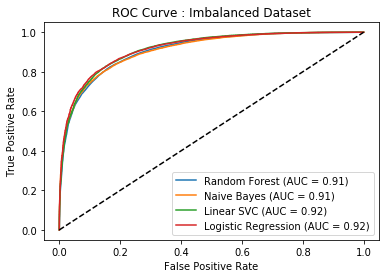

In [122]:
# plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(rf_imbal, X_test_imbal, y_test_imbal, name='Random Forest', ax=ax) #specify axis to plot all roc curves on the same axis
plot_roc_curve(nb_imbal, X_test_imbal, y_test_imbal, name='Naive Bayes', ax=ax)
plot_roc_curve(svc_imbal, X_test_imbal, y_test_imbal, name='Linear SVC', ax=ax)
plot_roc_curve(log_imbal, X_test_imbal, y_test_imbal, name='Logistic Regression', ax=ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve : Imbalanced Dataset')
plt.show()

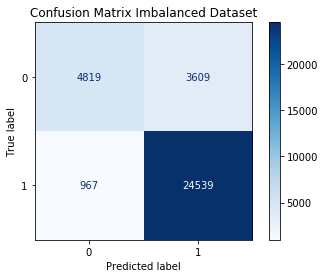

In [124]:
# plot confusion matrix for imbalanced dataset
plot_confusion_matrix(svc_imbal, X_test_imbal, y_test_imbal,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix Imbalanced Dataset')
plt.show()

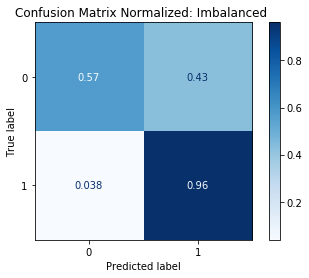

In [125]:
# plot confusion matrix for imbalanced dataset
plot_confusion_matrix(svc_imbal, X_test_imbal, y_test_imbal,cmap=plt.cm.Blues, normalize='true')  
plt.title('Confusion Matrix Normalized: Imbalanced ')
plt.show()

### References and Possible Future Extensions